In [1]:
from sys import path
path.append('../tools')
from tools import gen_inputs_outputs, gen_pair_inputs
from tensorflow import keras
from keras import layers, Sequential, Input, metrics
import matplotlib.pyplot as plt

2024-07-21 11:42:05.163126: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 11:42:05.171642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 11:42:05.183868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 11:42:05.183883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 11:42:05.191771: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# For these calculations, we change the input so that
# the layers are in units of 2

In [5]:
# We start with two bit calculations
R = 4
x_train, y_train, S = gen_inputs_outputs(R)
x_train = gen_pair_inputs(x_train)
x_train

{'unit_0': array([[0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 1],
        [1, 1],
        [1, 0],
        [1, 0],
        [1, 1],
        [1, 1]]),
 'unit_1': array([[0, 0],
        [0, 1],
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [1, 0],
        [1, 1],
        [0, 0],
        [0, 1],
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
        [1, 0],
        [1, 1]])}

In [23]:
# Creates the unit inputs
def gen_unit_inputs(l):
    return [Input(shape=(2,), name=f'unit_{i}') for i in range(l)]

# Create the units
def gen_units(unit_inputs, size, activation):
    return [layers.Dense(size,
                         activation=activation,
                         use_bias=False,
                         name=f'dense_unit_{i}')(unit_input) for i, unit_input in enumerate(unit_inputs)]

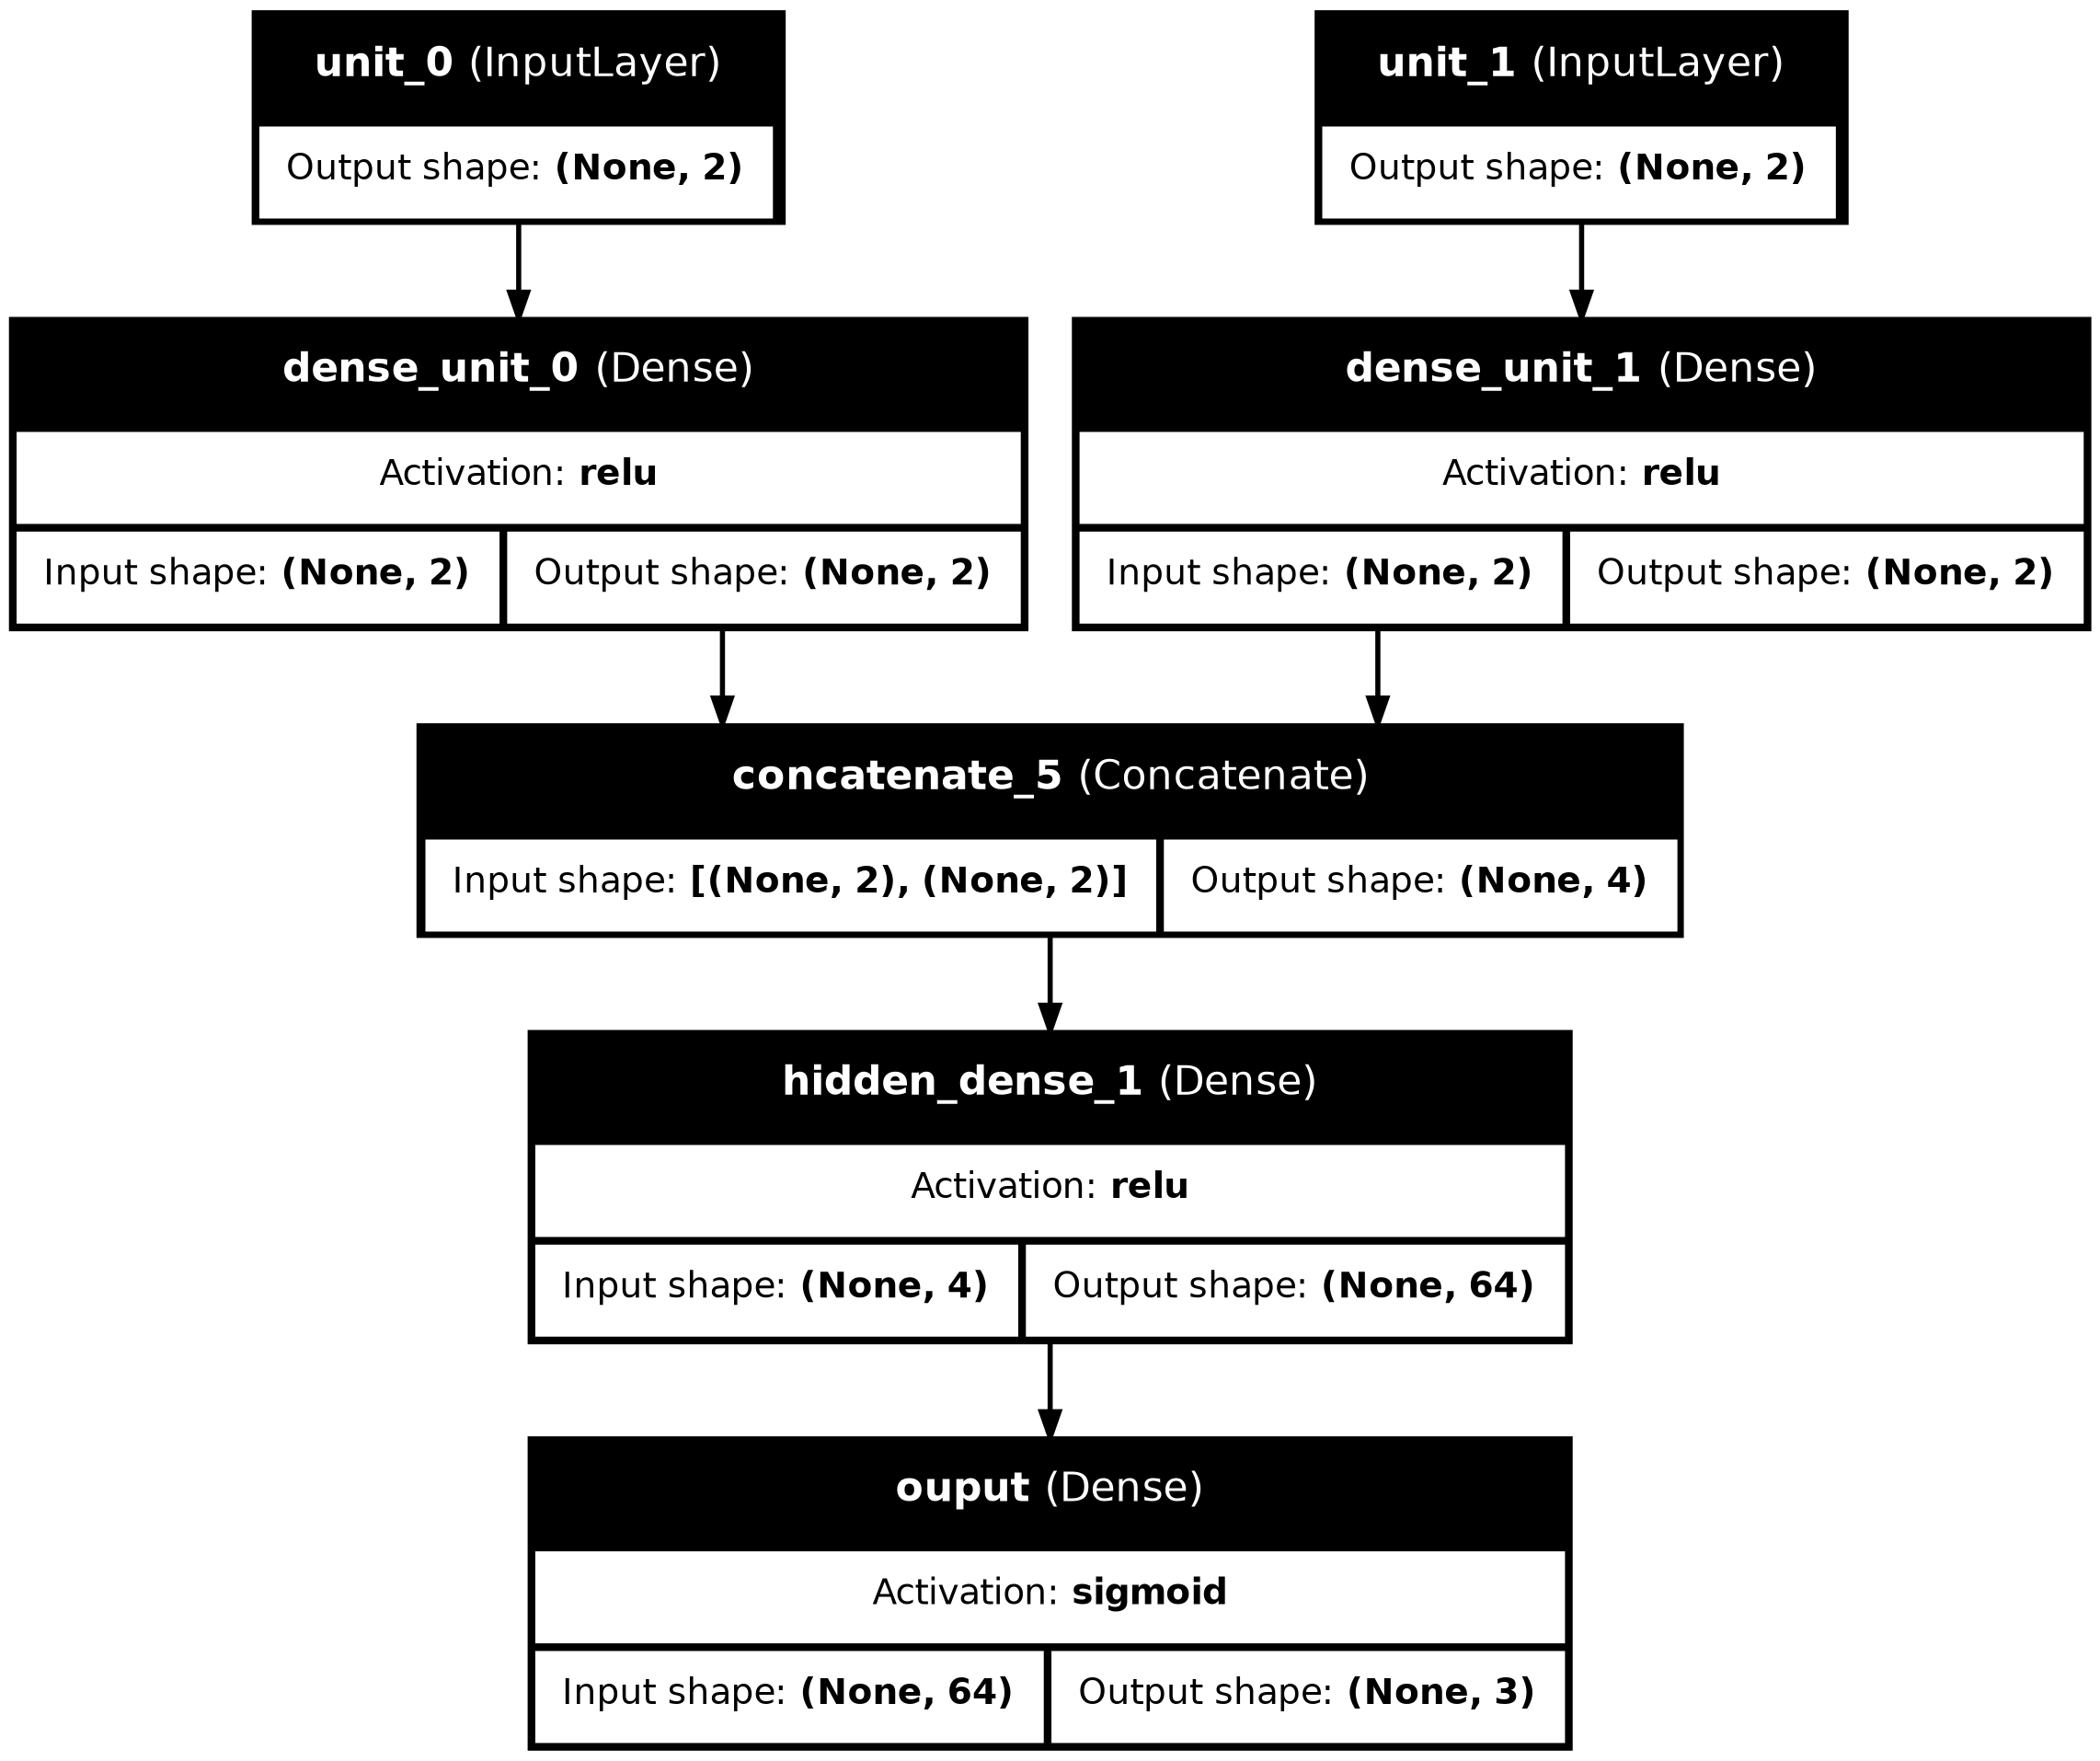

In [26]:
# Create the model
# Create the inputs
inputs = gen_unit_inputs(len(x_train))

# Create the units
x = layers.concatenate(gen_units(inputs, 2, activation='relu'))

# Add dense layers
x = layers.Dense(64, activation='relu', use_bias=False, name='hidden_dense_1')(x)

# Ouput layer
outputs = layers.Dense(S, activation='sigmoid', use_bias=False, name='ouput')(x)

model = keras.Model(
    inputs=inputs,
    outputs=outputs
)

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    to_file='model.png',
)

In [27]:
# Compile and train the moded
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 200
BATCH_SIZE = None

model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=None
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step - binary_accuracy: 0.6250 - loss: 0.6903
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.6250 - loss: 0.6897
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6250 - loss: 0.6892
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6250 - loss: 0.6887
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6250 - loss: 0.6881
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6250 - loss: 0.6876
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6250 - loss: 0.6870
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6458 - loss: 0.6865
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6458 - loss: 0.6860
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6458 - loss: 0.6854
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6458 - loss: 0.6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7083 - loss: 0.6493
Epoch 67/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6485
Epoch 68/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6476
Epoch 69/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6468
Epoch 70/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6460
Epoch 71/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6451
Epoch 72/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6443
Epoch 73/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6434
Epoch 74/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6425
Epoch 75/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7083 - loss: 0.6416
Epoch 76/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7083 - loss: 0.6407
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5832
Epoch 131/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5820
Epoch 132/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5808
Epoch 133/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5795
Epoch 134/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7292 - loss: 0.5783
Epoch 135/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5770
Epoch 136/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7292 - loss: 0.5758
Epoch 137/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7292 - loss: 0.5746
Epoch 138/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5734
Epoch 139/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss: 0.5722
Epoch 140/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7292 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7500 - loss: 0.5105
Epoch 195/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7500 - loss: 0.5094
Epoch 196/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.7500 - loss: 0.5084
Epoch 197/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7500 - loss: 0.5075
Epoch 198/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7500 - loss: 0.5065
Epoch 199/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7500 - loss: 0.5055
Epoch 200/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7500 - loss: 0.5046


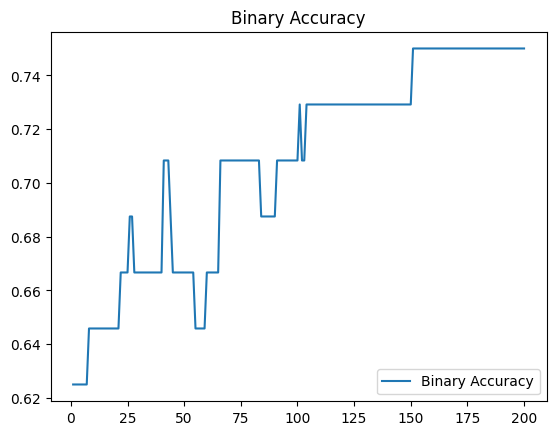

In [28]:
x_points = [i for i in range(1, EPOCHS+1)]

plt.plot(x_points, history.history['binary_accuracy'], label='Binary Accuracy')
plt.title('Binary Accuracy')
plt.legend(loc='lower right')

plt.show()